### Feature engineering using wavelet transform

In [1]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

### Generate features and create dataset

In [2]:
import os

X, y = [], []
cls = 0
CLEANED_DS_PATH = "./data/cleaned_images/"
for d in os.scandir(CLEANED_DS_PATH):
    if d.is_dir():
        for f in os.scandir(d):
            img = cv2.imread(f.path)
            scaled_img = cv2.resize(img, (32, 32))
            wavelet_img = w2d(img, 'db1', 5)
            scaled_wavelet_img = cv2.resize(wavelet_img, (32, 32))
            stacked_img = np.vstack((scaled_img.reshape(-1, 1), scaled_wavelet_img.reshape(-1, 1)))
            X.append(stacked_img)
            y.append(cls)
        cls += 1

In [3]:
X = np.array(X).reshape(len(X), -1).astype(float)
X.shape

(121, 4096)

### Quick litmus test for good models to try

In [4]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)
X_train.reshape(len(X_train), -1)
X_test.reshape(len(X_test), -1)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

 97%|█████████▋| 28/29 [00:16<00:00,  1.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111317
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 4096
[LightGBM] [Info] Start training from score -1.339774
[LightGBM] [Info] Start training from score -1.295323
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.540445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Training a first cut RidgeClassifierCV

In [5]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()), ('clf', RidgeClassifierCV())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', RidgeClassifierCV())])

In [7]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       1.00      0.86      0.92         7
           3       0.78      0.88      0.82         8

    accuracy                           0.89        37
   macro avg       0.89      0.90      0.89        37
weighted avg       0.91      0.89      0.89        37



### Try hyperparameter tuning in combination with other models

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
models = {
    'ridge': RidgeClassifier(),
    'logistic_regression': LogisticRegression(solver='liblinear', max_iter=200), # small dataset
    'random_forest': RandomForestClassifier()
}
params = {
    'ridge': {
        'ridgeclassifier__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
    },
    'logistic_regression': {
        'logisticregression__C': [0.01, 0.1, 1, 5, 10]
    },
    'random_forest': {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [None, 10, 20],
        'randomforestclassifier__min_samples_split': [2, 5],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4]
    }
}

In [23]:
import pandas as pd

scores = []
best_estimators = {}
for model in models.keys():
    pipe = make_pipeline(StandardScaler(), models[model])
    clf =  GridSearchCV(pipe, params[model])
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[model] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,ridge,0.87,{'ridgeclassifier__alpha': 0.1}
1,logistic_regression,0.85,{'logisticregression__C': 1}
2,random_forest,0.88,"{'randomforestclassifier__max_depth': None, 'r..."


### The ridge classifier still comes out on top

In [24]:
print(classification_report(y_test, best_estimators['ridge'].predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.78      1.00      0.88         7
           2       1.00      0.86      0.92         7
           3       0.78      0.88      0.82         8

    accuracy                           0.89        37
   macro avg       0.89      0.90      0.89        37
weighted avg       0.91      0.89      0.89        37



In [25]:
print(classification_report(y_test, best_estimators['logistic_regression'].predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.70      1.00      0.82         7
           2       1.00      0.71      0.83         7
           3       0.70      0.88      0.78         8

    accuracy                           0.84        37
   macro avg       0.85      0.85      0.83        37
weighted avg       0.88      0.84      0.84        37



In [26]:
print(classification_report(y_test, best_estimators['random_forest'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.55      0.86      0.67         7
           2       0.67      0.57      0.62         7
           3       0.70      0.88      0.78         8

    accuracy                           0.70        37
   macro avg       0.70      0.73      0.69        37
weighted avg       0.75      0.70      0.70        37



Text(33.22222222222222, 0.5, 'Truth')

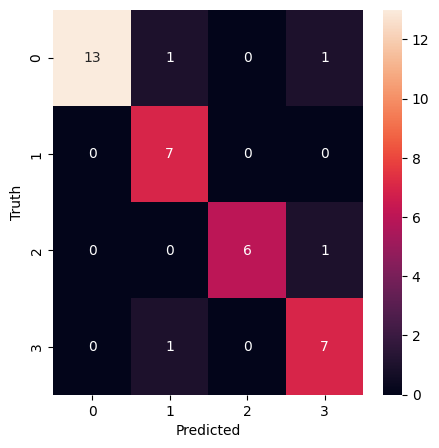

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_clf = best_estimators['ridge']
cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
import json

class_dict = {
    'lionel_messi': 0,
    'maria_sharapova': 1,
    'roger_federer': 2,
    'serena_williams': 3
}
with open('class_dict.json', 'w+') as f:
    json.dump(class_dict, f, indent=2)

### Pickle the trained model

In [32]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

### Since pickle is considered insecure, can also save params as a JSON

In [34]:
parameters = {}
for step_name, step in best_clf.named_steps.items():
    parameters[step_name] = {}
    if hasattr(step, 'get_params'):
        step_params = step.get_params()
        for param_name, param_value in step_params.items():
            parameters[step_name][param_name] = param_value

with open('pipeline_parameters.json', 'w') as json_file:
    json.dump(parameters, json_file, indent=2)